In [1]:
import json
import numpy as np
from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from hyperopt import hp, fmin, tpe, Trials
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from tensorflow.keras.callbacks import EarlyStopping

In this part, import the data and preprocess the data to be ready for the model. 
- The input data: lateral acceleration, steering wheel angle, lateral displacement, yaw rate, and steering wheel angluar velocity. 
- The data is collected at 100Hz, and the model is trained at 30Hz. 
- Time window: 10 seconds with a step of 1 second. 

In [2]:
os.chdir('/Users/ruotsing/PycharmProjects/DMS')

with open('preprocess_data/lateral_acceleration_data.json', 'r') as f:
    LA_data = json.load(f)
    
    
with open('preprocess_data/SWA_data.json', 'r') as f:
    SWA_data = json.load(f)

with open('preprocess_data/lateral_displacement_data.json', 'r') as f:
    LD_data = json.load(f)
    
with open('preprocess_data/YA_data.json', 'r') as f:
    YA_data = json.load(f)
    
with open('preprocess_data/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
    
def time_derivative(data, time_interval):
    data_dt = {}
    for name in data.keys():
        delta_displacement = np.diff(data[name])
        data_dt[name] = np.gradient(delta_displacement, time_interval)
    return data_dt

def simulate_decrease_sample_rate_regular(data,original_rate,target_rate):
    processed_data = {}
    for name in data.keys():
        processed_data[name] = []
        for i in range(0, len(data[name]), int(original_rate/target_rate)):
            processed_data[name].append(data[name][i])
    return processed_data

original_sample_rate = 100
target_sample_rate = 30

LA_data = simulate_decrease_sample_rate_regular(LA_data, original_sample_rate, target_sample_rate)
SWA_data = simulate_decrease_sample_rate_regular(SWA_data, original_sample_rate, target_sample_rate)
LD_data = simulate_decrease_sample_rate_regular(LD_data, original_sample_rate, target_sample_rate)
YA_data = simulate_decrease_sample_rate_regular(YA_data, original_sample_rate, target_sample_rate)


sample_rate = target_sample_rate
SWV_data= time_derivative(SWA_data, 1/sample_rate)
YR_data= time_derivative(YA_data, 1/sample_rate)

#standardize the data
def standardize(data):
    data_standard = {}
    for name in data.keys():
        data_standard[name] = (data[name] - np.mean(data[name]))/np.std(data[name])
    return data_standard

YR_standard = standardize(YR_data)
SWA_standard = standardize(SWA_data)
SWV_standard = standardize(SWV_data)
LD_standard = standardize(LD_data)
LA_standard = standardize(LA_data)

#apply the time window
size_= 10
step = 1
ground_truth=reform_ground_truth(ground_truth)
awake_window, _, drowsy_window=ground_truth_sep(ground_truth,size_,step) #ignoew the light drowsy state

def define_feature_matrix(window, data):
    feature_matrix = []
    for name in window.keys():
        for i in range(len(window[name])):
            begin = window[name][i][0]*sample_rate
            end = (window[name][i][-1]+1)*sample_rate
            feature_matrix.append(data[name][begin:end])
    return np.array(feature_matrix)
    

awake_YR_feature = define_feature_matrix(awake_window, YR_standard)
awake_SWA_feature = define_feature_matrix(awake_window, SWA_standard)
awake_SWV_feature = define_feature_matrix(awake_window, SWV_standard)
awake_LD_feature = define_feature_matrix(awake_window, LD_standard)
awake_LA_feature = define_feature_matrix(awake_window, LA_standard)
awake_feature_matrix=np.dstack((awake_YR_feature, awake_SWA_feature, awake_SWV_feature, awake_LD_feature, awake_LA_feature))
awake_label = np.ones(awake_feature_matrix.shape[0])*0

drowsy_YR_feature = define_feature_matrix(drowsy_window, YR_standard)
drowsy_SWA_feature = define_feature_matrix(drowsy_window, SWA_standard)
drowsy_SWV_feature = define_feature_matrix(drowsy_window, SWV_standard)
drowsy_LD_feature = define_feature_matrix(drowsy_window, LD_standard)
drowsy_LA_feature = define_feature_matrix(drowsy_window, LA_standard)
drowsy_feature_matrix=np.dstack((drowsy_YR_feature, drowsy_SWA_feature, drowsy_SWV_feature, drowsy_LD_feature, drowsy_LA_feature))
drowsy_label=np.ones(drowsy_feature_matrix.shape[0])


feature_matrix=np.concatenate((awake_feature_matrix, drowsy_feature_matrix), axis=0)
label=np.concatenate((awake_label, drowsy_label), axis=0)
label=label.astype(int)

weight_for_0 = (1 / len(awake_label)) * (len(label) / 2.0) #awake
weight_for_1 = (1 / len(drowsy_label)) * (len(label) / 2.0) #drowsy
class_weight = {0: weight_for_0, 1: weight_for_1}

Make the model

In [11]:
def make_model():
    model=tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(feature_matrix.shape[1], feature_matrix.shape[2])),
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(32, 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(3),
        
        tf.keras.layers.Conv1D(32, 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(3),
        
        tf.keras.layers.Conv1D(128, 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(3),
        
        tf.keras.layers.Conv1D(64, 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(3),
        
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=1.5), metrics=[Recall(name='recall'),Precision(name='precision')]) 
    return model

def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    threshold = len(drowsy_label)/(len(awake_label))
    y_pred=[]
    for row in model.predict(X_test):
        y_pred.append(np.argmax(row))
        # if row[1]>threshold:
        #     y_pred.append(1)
        # else:
        #     y_pred.append(0)
    y_pred=np.array(y_pred) 
    cm = confusion_matrix(y_test, y_pred)
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('Precision:', cm[1,1]/(cm[1,1]+cm[0,1]))
    print('specificity:', cm[0,0]/(cm[0,0]+cm[0,1]))
    print('sensitivity:', cm[1,1]/(cm[1,1]+cm[1,0]))
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Awake', 'Drowsy'], yticklabels=['Awake', 'Drowsy'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()

Apply the model to the data(using cross validation)

Epoch 1/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0905 - precision: 0.6814 - recall: 0.6814
Epoch 2/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0452 - precision: 0.8491 - recall: 0.8491
Epoch 3/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0309 - precision: 0.8821 - recall: 0.8821
Epoch 4/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0271 - precision: 0.9035 - recall: 0.9035
Epoch 5/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0210 - precision: 0.9179 - recall: 0.9179
Epoch 6/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0163 - precision: 0.9377 - recall: 0.9377
Epoch 7/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0169 - precision: 0.9425 - recall: 0.9425
Epoch 8/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0160 - precision: 0.9376 - recall: 0.9376
Epoch 9/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0106 - precision: 0.9605 - recall: 0.9605
Epoch 10/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step -

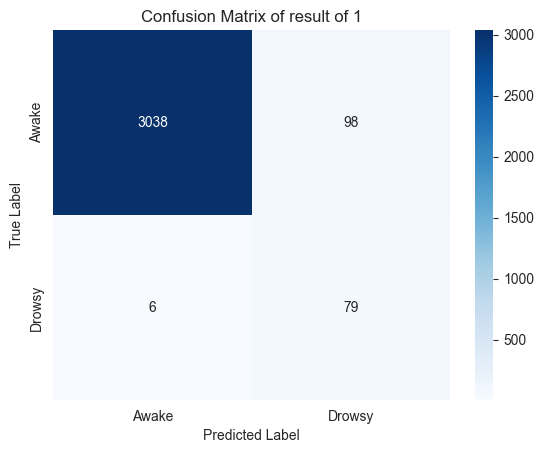

Epoch 1/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0874 - precision: 0.7427 - recall: 0.7427
Epoch 2/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0505 - precision: 0.8094 - recall: 0.8094
Epoch 3/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0314 - precision: 0.8806 - recall: 0.8806
Epoch 4/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0348 - precision: 0.8630 - recall: 0.8630
Epoch 5/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0224 - precision: 0.9139 - recall: 0.9139
Epoch 6/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0199 - precision: 0.9248 - recall: 0.9248
Epoch 7/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0143 - precision: 0.9432 - recall: 0.9432
Epoch 8/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0175 - precision: 0.9392 - recall: 0.9392
Epoch 9/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0088 - precision: 0.9675 - recall: 0.9675
Epoch 10/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step -

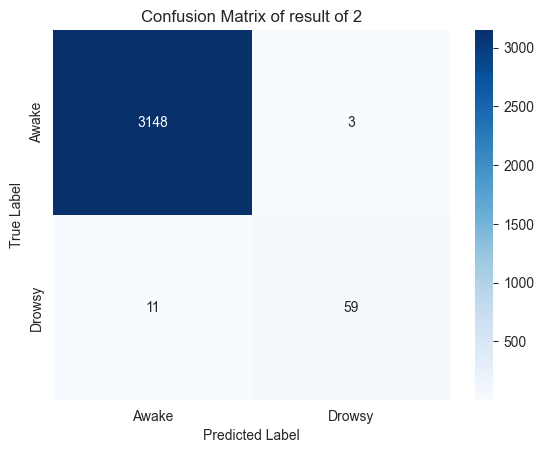

Epoch 1/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0965 - precision: 0.6678 - recall: 0.6678
Epoch 2/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0521 - precision: 0.8029 - recall: 0.8029
Epoch 3/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0363 - precision: 0.8478 - recall: 0.8478
Epoch 4/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0392 - precision: 0.8416 - recall: 0.8416
Epoch 5/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0273 - precision: 0.8812 - recall: 0.8812
Epoch 6/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0323 - precision: 0.8674 - recall: 0.8674
Epoch 7/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0220 - precision: 0.9044 - recall: 0.9044
Epoch 8/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0167 - precision: 0.9348 - recall: 0.9348
Epoch 9/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0228 - precision: 0.9145 - recall: 0.9145
Epoch 10/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step -

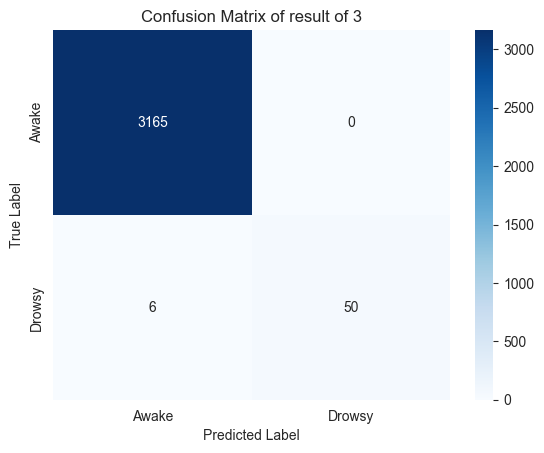

Epoch 1/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0944 - precision: 0.6593 - recall: 0.6593
Epoch 2/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0501 - precision: 0.8030 - recall: 0.8030
Epoch 3/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0366 - precision: 0.8574 - recall: 0.8574
Epoch 4/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0305 - precision: 0.8848 - recall: 0.8848
Epoch 5/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0289 - precision: 0.8952 - recall: 0.8952
Epoch 6/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0224 - precision: 0.9174 - recall: 0.9174
Epoch 7/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0203 - precision: 0.9253 - recall: 0.9253
Epoch 8/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0145 - precision: 0.9479 - recall: 0.9479
Epoch 9/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0249 - precision: 0.9085 - recall: 0.9085
Epoch 10/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step -

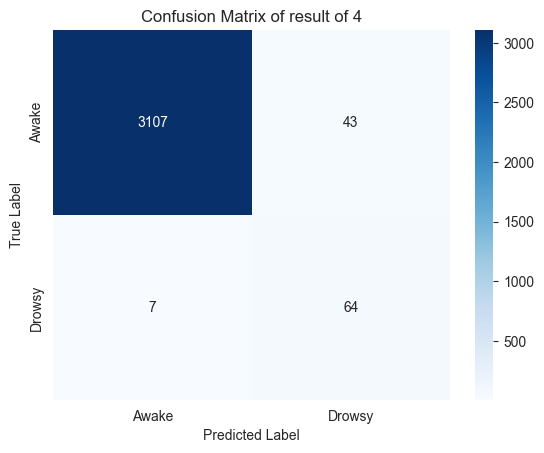

Epoch 1/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0917 - precision: 0.6762 - recall: 0.6762
Epoch 2/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0420 - precision: 0.8520 - recall: 0.8520
Epoch 3/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0293 - precision: 0.8902 - recall: 0.8902
Epoch 4/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0235 - precision: 0.9131 - recall: 0.9131
Epoch 5/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0233 - precision: 0.9215 - recall: 0.9215
Epoch 6/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0196 - precision: 0.9221 - recall: 0.9221
Epoch 7/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0132 - precision: 0.9516 - recall: 0.9516
Epoch 8/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0120 - precision: 0.9548 - recall: 0.9548
Epoch 9/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0146 - precision: 0.9486 - recall: 0.9486
Epoch 10/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step -

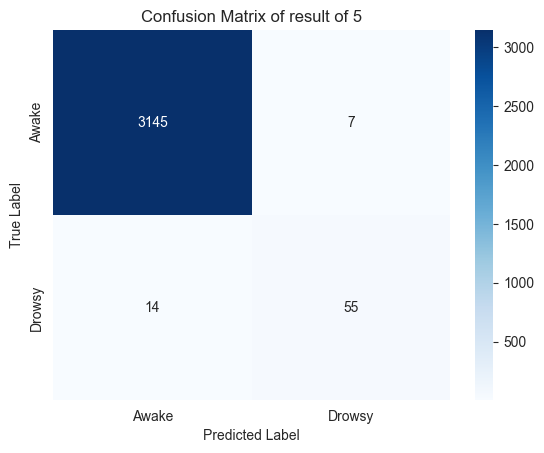

Epoch 1/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0917 - precision: 0.6046 - recall: 0.6046
Epoch 2/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0458 - precision: 0.8334 - recall: 0.8334
Epoch 3/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0381 - precision: 0.8479 - recall: 0.8479
Epoch 4/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0236 - precision: 0.9088 - recall: 0.9088
Epoch 5/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0278 - precision: 0.8920 - recall: 0.8920
Epoch 6/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0222 - precision: 0.9171 - recall: 0.9171
Epoch 7/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0163 - precision: 0.9396 - recall: 0.9396
Epoch 8/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0143 - precision: 0.9470 - recall: 0.9470
Epoch 9/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0141 - precision: 0.9498 - recall: 0.9498
Epoch 10/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step -

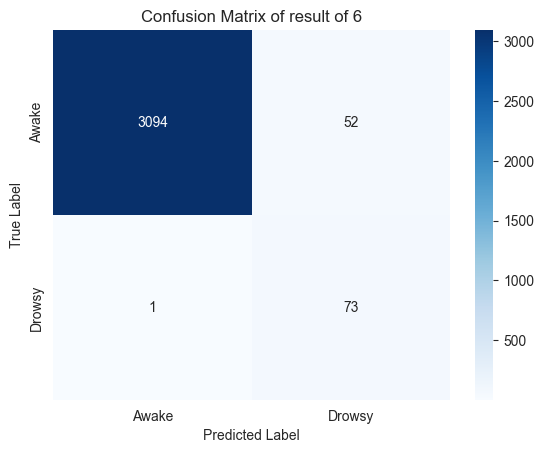

In [14]:

kf = KFold(n_splits=6, shuffle=True)
fold_no = 1
for train,test in kf.split(feature_matrix, label):
    model=make_model()
    model.fit(feature_matrix[train], to_categorical(label[train]), epochs=70, batch_size=128, verbose=1, class_weight=class_weight)
    
    scores = model.evaluate(feature_matrix[test], to_categorical(label[test]), verbose=0)
            
    confusion_matrix_on_test_data(model, f'result of {fold_no}', feature_matrix[test], label[test])        
    fold_no += 1